### Import packages

In [1]:
import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import *
from PREDICT.Metrics import *
from PREDICT.Triggers import *
from PREDICT.Plots import *
from Comparison.Detect_Functions import *
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime
import statistics
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Comparing Methods to Repair Temporal Drift

In this notebook, four methods to repair temporal drift are compared:

1) Regular model testing
2) Statistical process control
3) Static threshold
4) Bayesian variable relative change



These methods are compared for four scenarios:

1) Fast predictor change - COVID pandemic
2) Slow predictor change - population-based diabetes increase
3) Outcome drift - change in prevalence of diabetes mellitus
4) Multivariate drift - the diabetes prevalence increases whilst smoking prevalence decreases


In [2]:
startDate = pd.to_datetime('01-06-2019', dayfirst=True) # 01-06-2019
endDate = pd.to_datetime('31-12-2021', dayfirst=True)
num_patients = 40 # number of patients per each timestep

#### Fast Change - COVID Data Simulation

In [3]:
total_runs = 0
recalthreshold = 0.86 # Paper has AUROC of 0.91, with lower CI at 0.86

custom_impacts = [0.1]#, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 2.5, 3.0]
switchDateStrings = ['01-04-2020'] # Keep this as just one switchDate as other methods only look at one startDate/deployment date
undetected = dict({"Static Threshold": 0, "Regular Testing": 0, "SPC3": 0, "SPC5":0, "SPC7":0, "Bayesian": 0})

hr_age = 0.5
hr_ldh = 9.8
hr_comorbidity = 3.9

log_age = np.log(hr_age)
log_ldh = np.log(hr_ldh)
log_comorbidity = np.log(hr_comorbidity)

for switchDateidx, switchDateString in enumerate(switchDateStrings):
    for custom_impact in custom_impacts:
        mydict = {
                'date': list(),
                'outcome': list(),
                'prediction': list(),
                'age': list(),
                'sex': list(),
                'comorbidity': list(),
                'ldh_high': list()
            }

        # Define date range and COVID shock periods
        switchDate = pd.to_datetime(switchDateString, dayfirst=True)  # COVID starts spreading
        switchDate2 = pd.to_datetime('01-06-2020', dayfirst=True)  # Peak of the pandemic
        recoveryDate = pd.to_datetime('01-06-2021', dayfirst=True)  # Start of recovery phase
        numdays = (endDate - startDate).days
        switchDays = (switchDate - startDate).days
        switch2Days = (switchDate2 - startDate).days
        recoveryDays = (recoveryDate - startDate).days

        for i in range(numdays):
            curday = startDate + dt.timedelta(days=i)

            age = np.random.normal(44, 16.3, num_patients)  # Mean age 44 years, std 16.3
            sex = np.random.binomial(1, 0.562, num_patients) # 56.2% are male
            comorbidity = np.random.binomial(1, 0.3, num_patients)  # 30% have comorbidities
            ldh_high = np.random.binomial(1, 0.15, num_patients)  # 15% have LDH >500 U/L

            # Calculate baseline log-odds
            # sex influence 1.2 due to not being provided in the paper
            lp = -1.5 + log_age * (age - 44) / 16.3 +  log_ldh * (ldh_high - 0.15) + log_comorbidity * (comorbidity - 0.3) + 1.2 * (sex - 0.562)
            curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability

            # Simulate COVID effects
            if switchDays <= i < switch2Days:
                lp += custom_impact  # Initial impact of COVID
            elif switch2Days <= i < recoveryDays:
                lp += custom_impact + 0.5  # Peak of the pandemic
            elif i >= recoveryDays:
                lp -= 1.0  # Recovery period—improved health outcomes

            # Generate outcomes
            curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))  # Simulate COVID events

            # Append to dictionary
            mydict['date'].extend([curday] * num_patients)
            mydict['outcome'].extend(curoutcomes)
            mydict['prediction'].extend(curpredictions)
            mydict['age'].extend(age)
            mydict['sex'].extend(sex)
            mydict['comorbidity'].extend(comorbidity)
            mydict['ldh_high'].extend(ldh_high)

        df = pd.DataFrame(mydict)

        covid_metrics_df = get_metrics_recal_methods(df, custom_impact, recalthreshold)

        ########################################### Bayesian Testing #######################################
        # bay_model = BayesianModel(input_data=df, priors={"Intercept": (-1, 2), "age": (log_age, 2), "sex": (1, 2), "comorbidity": (log_comorbidity, 2), "ldh_high": (log_ldh, 2)}, cores=4, verbose=False, draws=1000, tune=250, chains=4)
        # bay_model.trigger = BayesianRefitTrigger(model=bay_model, input_data=df, refitFrequency=1)
        # mytest = PREDICT(data=df, model=bay_model, startDate='min', endDate='max', timestep='month')
        # mytest.addLogHook(Accuracy(model))
        # mytest.addLogHook(AUROC(model))
        # mytest.addLogHook(Precision(model))
        # mytest.run()
        # log = mytest.getLog()

        # bayes_metrics = pd.DataFrame({'Time': list(log["Accuracy"].keys()), 'Accuracy': list(log["Accuracy"].values()), 'AUROC': list(log["AUROC"].values()), 'Precision': list(log["Precision"].values()), 'impact_or_prev': list([str(custom_impact)] * len(log["Accuracy"])), 'Method':list(['Bayesian'] * len(log["Accuracy"]))})
        
        ########################################### Save Metrics #######################################

        # concatenate all the dataframes into one
        #covid_metrics_df = pd.concat([covid_metrics_df, bayes_metrics], ignore_index=True)
        covid_metrics_df["Data_Type"] = "COVID Simulation"

        covid_metrics_df.to_csv('performance_metrics.csv', mode='a', header=False, index=False)
            

#### Outcome Prevalence - Diabetes Outcome Predicted

In [5]:
total_runs = 0
recalthreshold = 0.77 # Paper has AUROC of 0.81, with lower CI at 0.77 

prev_increases = 1.0001 #np.arange(1.0001, 1.003, 0.0002).tolist()
undetected = dict({"Static Threshold": 0, "Regular Testing": 0, "SPC3": 0, "SPC5": 0, "SPC7": 0, "Bayesian": 0})

# coefficients from non-laboratory logistic regression model
age_at_lv_coef = 0.16 # lv = last visit
bmi_coef = 0.68
hip_circ_coef = -0.05
sex_coef = -0.14
height_coef = -0.15
waist_circ_coef = 0.31
waist_hips_ratio_coef = 0.54
weight_coef = 0.03
time_between_visits_coef = 0.38
bias_coef = -0.74

# mean and standard deviation for each predictor
# variable at the last visit is used
mean_age, std_age = 62.9, 7.5
mean_bmi, std_bmi = 26.6, 4.4
mean_hip_circ, std_hip_circ = 101.6, 8.8
perc_male, mean_height, std_height = 0.478, 169, 9.2
mean_waist_circ, std_waist_circ = 88.7, 12.7
mean_weight, std_weight = 76.2, 15.2
mean_time_between_visits, std_time_between_visits = 7.3, 2.3

mean_waist_hips_ratio = mean_waist_circ / mean_hip_circ
std_waist_hips_ratio = mean_waist_hips_ratio * np.sqrt(
    (std_waist_circ / mean_waist_circ) ** 2 + (std_hip_circ / mean_hip_circ) ** 2)

dm_prev = 0.07  # Initial diabetes prevalence = 7%
for prev_increase in prev_increases:
    mydict = {
            'date': list(),
            'outcome': list(),
            'prediction': list(),
            'age': list(),
            'bmi':list(),
            'hip_circ': list(),
            'sex': list(),
            'height': list(),
            'waist_circ': list(),
            'waist_hips_ratio': list(),
            'weight': list(),
            'time_between_visits': list()
        }

    num_patients = 60
    numdays = (endDate - startDate).days
    
    for i in range(numdays):
        curday = startDate + dt.timedelta(days=i)

        age = np.random.normal(mean_age, std_age, num_patients)
        bmi = np.random.normal(mean_bmi, std_bmi, num_patients)
        hip_circ = np.random.normal(mean_hip_circ, std_hip_circ, num_patients)
        sex = np.random.binomial(1, perc_male, num_patients)
        height = np.random.normal(mean_height, std_height, num_patients)
        waist_circ = np.random.normal(mean_waist_circ, std_waist_circ, num_patients)
        waist_hips_ratio = np.random.normal(mean_waist_hips_ratio, std_waist_hips_ratio, num_patients)
        weight = np.random.normal(mean_weight, std_weight, num_patients)
        time_between_visits = np.random.normal(mean_time_between_visits, std_time_between_visits, num_patients)

        # Calculate baseline log-odds
        lp = bias_coef + age_at_lv_coef * (age - mean_age)/std_age + bmi_coef * (bmi - mean_bmi)/std_bmi + hip_circ_coef * (hip_circ - mean_hip_circ)/std_hip_circ + sex_coef * (sex - perc_male) + height_coef * (height - mean_height)/std_height + waist_circ_coef * (waist_circ - mean_waist_circ)/std_waist_circ + waist_hips_ratio_coef * (waist_hips_ratio - mean_waist_hips_ratio)/std_waist_hips_ratio + weight_coef * (weight - mean_weight)/std_weight + time_between_visits_coef * (time_between_visits - mean_time_between_visits)/std_time_between_visits
        curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability

        # Generate outcomes to simulate diabetes rates increasing over time
        if i % 30 == 0:
            dm_prev *= prev_increase # this increases the probability by x% each month

        mod_lp = 1/(1+np.exp(lp + dm_prev))
        # intercept changed, but model weights constant
        # diabetes increased as outcome, but not explained by data
        curoutcomes = np.random.binomial(1, mod_lp)           
        

        # Append to dictionary from the distribution for each of the variables (Table 1)
        mydict['date'].extend([curday] * num_patients)
        mydict['outcome'].extend(curoutcomes)
        mydict['prediction'].extend(curpredictions)
        mydict['age'].extend(age)
        mydict['bmi'].extend(bmi)
        mydict['hip_circ'].extend(hip_circ)
        mydict['sex'].extend(sex)
        mydict['height'].extend(height)
        mydict['waist_circ'].extend(waist_circ)
        mydict['waist_hips_ratio'].extend(waist_hips_ratio)
        mydict['weight'].extend(weight)
        mydict['time_between_visits'].extend(time_between_visits)
        

    df = pd.DataFrame(mydict)  
    out_prev_metrics_df = get_metrics_recal_methods(df, dm_prev, recalthreshold)
    
    
    ########################################### Bayesian Testing #######################################
    # bay_model = BayesianModel(input_data=df, priors={"Intercept": (bias_coef, 2), "age": (age_at_lv_coef, 2), "bmi": (bmi_coef, 2), "hip_circ": (hip_circ_coef, 2),
    #                                             "sex": (sex_coef, 2), "height":(height_coef, 2), "waist_circ":(waist_circ_coef, 2),
    #                                             "waist_hips_ratio":(waist_hips_ratio_coef, 2), "weight":(weight_coef, 2), 
    #                                             "time_between_visits":(time_between_visits_coef, 2)}, cores=4, verbose=False)
    # bay_model.trigger = BayesianRefitTrigger(model=bay_model, input_data=df, refitFrequency=1)
    # mytest = PREDICT(data=df, model=bay_model, startDate='min', endDate='max', timestep='month')
    # mytest.addLogHook(Accuracy(model))
    # mytest.addLogHook(AUROC(model))
    # mytest.addLogHook(Precision(model))
    # mytest.run()
    # log = mytest.getLog()

    # bayes_metrics = pd.DataFrame({'Time': list(log["Accuracy"].keys()), 'Accuracy': list(log["Accuracy"].values()), 'AUROC': list(log["AUROC"].values()), 'Precision': list(log["Precision"].values()), 'impact_or_prev': list([str(dm_prev)] * len(log["Accuracy"])), 'Method':list(['Bayesian'] * len(log["Accuracy"]))})
    
    ########################################### Save Metrics #######################################

    # concatenate all the dataframes into one
    #out_prev_metrics_df = pd.concat([out_prev_metrics_df, bayes_metrics], ignore_index=True)
    out_prev_metrics_df["Data_Type"] = "Outcome Prevalence Simulation"

    out_prev_metrics_df.to_csv('performance_metrics.csv', mode='a', header=False, index=False)


#### Slow change data simulation - Diabetes as a Predictor (increasing over time) with CKD as the predicted outcome.

In [6]:
total_runs = 0
recalthreshold = 0.851 # Paper has AUROC of 0.889, with lower CI at 0.851

prev_increases = 1.0001 #np.arange(1.0001, 1.0030, 0.0002).tolist()
undetected = dict({"Static Threshold": 0, "Regular Testing": 0, "SPC3": 0, "SPC5": 0, "SPC7": 0, "Bayesian": 0})

mean_TGFB, std_TGFB = 13.23, 5.18
mean_ADMA, std_ADMA= 101.1, 64.8
mean_BUN, std_BUN = 5.45, 1.11
mean_age, std_age = 63.27, 10.09 

TGFB_coef = 1.84
ADMA_coef = 1.137
DM_coef = 0.84
BUN_coef = 0.497
elderly_coef = 0.603

perc_dm = 0.05 # 5.5%
for prev_increase in prev_increases:
    mydict = {
            'date': list(),
            'outcome': list(),
            'prediction': list(),
            'TGFB': list(),
            'ADMA':list(),
            'DM': list(),
            'BUN': list(),
            'elderly': list()
        }

    num_patients = 60

    numdays = (endDate - startDate).days

    for i in range(numdays):
        curday = startDate + dt.timedelta(days=i)

        # increase the prevalence of diabetes over time
        if i % 30 == 0:
            perc_dm *= prev_increase # this increases the probability by x% each month

        TGFB = get_binom_from_normal(mean_TGFB, std_TGFB, num_patients, 1.011)
        ADMA = get_binom_from_normal(mean_ADMA, std_ADMA, num_patients, 0.019)
        DM = np.random.binomial(1, perc_dm, num_patients)
        BUN = get_binom_from_normal(mean_BUN, std_BUN, num_patients, 5.9)
        elderly = get_binom_from_normal(mean_age, std_age, num_patients, 60)

        # Calculate baseline log-odds
        # non_genetic_risk_score_model from paper
        lp = TGFB_coef * TGFB + ADMA_coef * ADMA + DM_coef * DM + BUN_coef * BUN + elderly_coef * elderly

        curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability
        curoutcomes = np.random.binomial(1, curpredictions)           
        
        # Append to dictionary from the distribution for each of the variables (Table 1)
        mydict['date'].extend([curday] * num_patients)
        mydict['outcome'].extend(curoutcomes)
        mydict['prediction'].extend(curpredictions)
        mydict['TGFB'].extend(TGFB)
        mydict['ADMA'].extend(ADMA)
        mydict['DM'].extend(DM)
        mydict['BUN'].extend(BUN)
        mydict['elderly'].extend(elderly)
        

    df = pd.DataFrame(mydict)
    slow_change_metrics_df = get_metrics_recal_methods(df, perc_dm, recalthreshold)
    

    ########################################### Bayesian Testing #######################################
    # bay_model = BayesianModel(input_data=df, priors={"Intercept": (-1, 2), "TGFB": (TGFB_coef, 2), "ADMA": (ADMA_coef, 2), "DM": (DM_coef, 2), "BUN": (BUN_coef, 2),
    #                                             "elderly": (elderly_coef, 2)}, cores=4, verbose=False)
    # bay_model.trigger = BayesianRefitTrigger(model=bay_model, input_data=df, refitFrequency=1)
    # mytest = PREDICT(data=df, model=bay_model, startDate='min', endDate='max', timestep='month')
    # mytest.addLogHook(Accuracy(model))
    # mytest.addLogHook(AUROC(model))
    # mytest.addLogHook(Precision(model))
    # mytest.run()
    # log = mytest.getLog()

    # bayes_metrics = pd.DataFrame({'Time': list(log["Accuracy"].keys()), 'Accuracy': list(log["Accuracy"].values()), 'AUROC': list(log["AUROC"].values()), 'Precision': list(log["Precision"].values()), 'impact_or_prev': list([str(perc_dm)] * len(log["Accuracy"])), 'Method':list(['Bayesian'] * len(log["Accuracy"]))})
    
    ########################################### Save Metrics #######################################

    # concatenate all the dataframes into one
    #slow_change_metrics_df = pd.concat([slow_change_metrics_df, bayes_metrics], ignore_index=True)
    slow_change_metrics_df["Data_Type"] = "Slow Change Simulation"

    slow_change_metrics_df.to_csv('performance_metrics.csv', mode='a', header=False, index=False)


#### Multivariate Model - QRISK2 - Diabetes increasing whilst smoking is decreasing.


In [7]:
recalthreshold = 0.811 # Paper has AUROC of 0.814, with lower CI at 0.811 

# Define the coefficients (hazard ratios converted to log-odds)
coefs = {"White": np.log(1), 
    "Indian": np.log(1.43),
    "Pakistani": np.log(1.8),
    "Bangladeshi": np.log(1.35),
    "Other_Asian": np.log(1.15),
    "Black_Caribbean": np.log(1.08),
    "Black_African": np.log(0.58),
    "Chinese": np.log(0.69),
    "Other": np.log(1.04),
    "Age": np.log(1.66),
    "BMI": np.log(1.08),
    "Townsend": np.log(1.37),
    "SBP": np.log(1.2),
    "CholHDL_ratio": np.log(1.17),
    "Family_CHD": np.log(1.99),
    "Current_smoker": np.log(1.8),
    "Treated_HTN": np.log(1.54),
    "DM": np.log(2.54),
    "RA": np.log(1.5),
    "AF": np.log(3.06),
    "Renal_disease": np.log(1.7),
    "Age_BMI": np.log(0.976),
    "Age_Townsend": np.log(0.938),
    "Age_SBP": np.log(0.966),
    "Age_Family_CHD": np.log(0.927),
    "Age_Smoking": np.log(0.931),
    "Age_Treated_HTN": np.log(0.952),
    "Age_DM": np.log(0.904),
    "Age_AF": np.log(0.858)
}


# Percentage variables (/100)
percent_family_history_chd = 0.126
percent_treated_hypertension = 0.0712
percent_rheumatoid_arthritis = 0.0093
percent_atrial_fibrillation = 0.0035
percent_renal_disease = 0.0016

# Age variable
median_age, IQR_age = 49, 19
mean_age, std_age = median_age, IQR_age / 1.35

# Mean and standard deviation variables
mean_bmi, std_bmi = 33.8, 6.1
mean_townsend, std_townsend = 17.67, 3.534
mean_sbp, std_sbp = 26.6, 4.4
mean_chol_hdl_ratio, std_chol_hdl_ratio = 3.66, 0.144


intercept = None
baseline_prob = 0.233 # 23.3%
total_runs = 0

prev_increases = 1.0001 # np.arange(1.0001, 1.003, 0.0002).tolist() # Increase in diabetes prevalence over time
smoking_decrease = 0.9995 # np.arange(0.9995, 0.9967, -0.0002).tolist()  # Decrease in smoking prevalence over time
undetected = dict({"Static Threshold": 0, "Regular Testing": 0, "SPC3": 0, "SPC5": 0, "SPC7": 0, "Bayesian": 0})

percent_type_2_diabetes = 0.017 # reset these for each start date
percent_current_smoker = 0.228
for num, prev_increase in enumerate(prev_increases):
    mydict = {
            'date': list(),
            'outcome': list(),
            'prediction': list(),
            'White': list(),
            'Indian': list(),
            'Pakistani': list(),
            'Bangladeshi': list(),
            'Other_Asian': list(),
            'Black_Caribbean': list(),
            'Black_African': list(),
            'Chinese': list(),
            'Other': list(),
            'Age': list(),
            'BMI':list(),
            'Townsend': list(),
            'SBP': list(),
            'CholHDL_ratio': list(),
            'Family_CHD': list(),
            'Current_smoker': list(),
            'Treated_HTN': list(),
            'DM': list(),
            'RA': list(),
            'AF': list(),
            'Renal_disease': list()
        }

    num_patients = 60

    # Define date range
    numdays = (endDate - startDate).days

    
    for i in range(numdays):
        curday = startDate + dt.timedelta(days=i)

        # increase the prevalence of diabetes over time
        if i % 30 == 0:
            percent_type_2_diabetes *= prev_increase # this increases the probability by x% each month
            percent_current_smoker *= smoking_decrease[num] # decrease the prevalence of smoking over time
        if percent_type_2_diabetes < 0 or percent_type_2_diabetes > 1:
            print("Percentage of people with DM", percent_type_2_diabetes)
        if percent_current_smoker < 0 or percent_current_smoker > 1:
            print("Percentage of people who are current smokers", percent_current_smoker)

        # Generate random factors for patients using z-score normalization for non-binary values
        pat_factors = {"Age": (np.random.normal(mean_age, std_age, num_patients) - mean_age) / std_age, 
            "BMI": (np.random.normal(mean_bmi, std_bmi, num_patients) - mean_bmi) /std_bmi,
            "Townsend": (np.random.normal(mean_townsend, std_townsend, num_patients) - mean_townsend) / std_townsend,
            "SBP": (np.random.normal(mean_sbp, std_sbp, num_patients) - mean_sbp) / std_sbp,
            "CholHDL_ratio": (np.random.normal(mean_chol_hdl_ratio, std_chol_hdl_ratio, num_patients) - mean_chol_hdl_ratio) / std_chol_hdl_ratio,
            "Family_CHD": np.random.binomial(1, percent_family_history_chd, num_patients),
            "Current_smoker": np.random.binomial(1, percent_current_smoker, num_patients),
            "Treated_HTN": np.random.binomial(1, percent_treated_hypertension, num_patients),
            "DM": np.random.binomial(1, percent_type_2_diabetes, num_patients),
            "RA": np.random.binomial(1, percent_rheumatoid_arthritis, num_patients),
            "AF": np.random.binomial(1, percent_atrial_fibrillation, num_patients),
            "Renal_disease": np.random.binomial(1, percent_renal_disease, num_patients)
        }

        ethnicity_assignment = select_ethnic_group(num_patients)
        pat_factors.update(ethnicity_assignment) # combine ethnicity dict with ethnic

        # Calculate baseline log-odds
        weighted_coef_sum = coefs['White']*pat_factors['White'] + coefs['Indian']*pat_factors['Indian'] + coefs['Pakistani']*pat_factors['Pakistani'] + coefs['Bangladeshi']*pat_factors['Bangladeshi'] 
        weighted_coef_sum += coefs['Other_Asian']*pat_factors['Other_Asian'] + coefs['Black_Caribbean']*pat_factors['Black_Caribbean'] + coefs['Black_African']*pat_factors['Black_African'] 
        weighted_coef_sum += coefs['Chinese']*pat_factors['Chinese'] + coefs['Other']*pat_factors['Other'] + coefs['Age']*(pat_factors['Age']) + coefs['BMI']*(pat_factors['BMI']) 
        weighted_coef_sum += coefs['Townsend']*(pat_factors['Townsend']) + coefs['SBP']*(pat_factors['SBP']) + coefs['CholHDL_ratio']*(pat_factors['CholHDL_ratio']) 
        weighted_coef_sum += coefs["Family_CHD"]*(pat_factors["Family_CHD"]) + coefs["Current_smoker"]*(pat_factors["Current_smoker"]) 
        weighted_coef_sum += coefs["Treated_HTN"]*(pat_factors["Treated_HTN"]) + coefs["DM"]*(pat_factors["DM"]) + coefs["RA"]*(pat_factors["RA"]) 
        weighted_coef_sum += coefs["AF"]*(pat_factors["AF"]) + coefs["Renal_disease"]*(pat_factors["Renal_disease"]) + (coefs["Age_BMI"] * pat_factors["Age"] * pat_factors["BMI"]) 
        weighted_coef_sum += (coefs["Age_Townsend"] * pat_factors["Age"] * pat_factors["Townsend"]) + (coefs["Age_SBP"] * pat_factors["Age"] * pat_factors["SBP"]) 
        weighted_coef_sum += (coefs["Age_Family_CHD"] * pat_factors["Age"] * pat_factors["Family_CHD"]) + (coefs["Age_Smoking"] * pat_factors["Age"] * pat_factors["Current_smoker"]) 
        weighted_coef_sum += (coefs["Age_Treated_HTN"] * pat_factors["Age"] * pat_factors["Treated_HTN"]) + (coefs["Age_DM"] * pat_factors["Age"] * pat_factors["DM"])
        weighted_coef_sum += (coefs["Age_AF"] * pat_factors["Age"] * pat_factors["AF"])

    
        intercept = np.log(baseline_prob / (1 - baseline_prob))
        
        # Compute log-odds
        lp = intercept + weighted_coef_sum
        lp = np.clip(lp, -500, 500)  # Clip to avoid overflow issues
        
        curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability
        
        
        curoutcomes = np.random.binomial(1, curpredictions)         
        

        # Append to dictionary from the distribution for each of the variables (Table 1)
        mydict['date'].extend([curday] * num_patients)
        mydict['outcome'].extend(curoutcomes)
        mydict['prediction'].extend(curpredictions)
        mydict['White'].extend(pat_factors['White'])
        mydict['Indian'].extend(pat_factors['Indian'])
        mydict['Pakistani'].extend(pat_factors['Pakistani'])
        mydict['Bangladeshi'].extend(pat_factors['Bangladeshi'])
        mydict['Other_Asian'].extend(pat_factors['Other_Asian'])
        mydict['Black_Caribbean'].extend(pat_factors['Black_Caribbean'])
        mydict['Black_African'].extend(pat_factors['Black_African'])
        mydict['Chinese'].extend(pat_factors['Chinese'])
        mydict['Other'].extend(pat_factors['Other'])
        mydict['Age'].extend(pat_factors['Age'])
        mydict['BMI'].extend(pat_factors['BMI'])
        mydict['Townsend'].extend(pat_factors['Townsend'])
        mydict['SBP'].extend(pat_factors['SBP'])
        mydict['CholHDL_ratio'].extend(pat_factors['CholHDL_ratio'])
        mydict['Family_CHD'].extend(pat_factors['Family_CHD'])
        mydict['Current_smoker'].extend(pat_factors['Current_smoker'])
        mydict['Treated_HTN'].extend(pat_factors['Treated_HTN'])
        mydict['DM'].extend(pat_factors['DM'])
        mydict['RA'].extend(pat_factors['RA'])
        mydict['AF'].extend(pat_factors['AF'])
        mydict['Renal_disease'].extend(pat_factors['Renal_disease'])

        

    df = pd.DataFrame(mydict)

    multivariate_metrics_df = get_metrics_recal_methods(df, percent_type_2_diabetes, recalthreshold)
    
    
    ########################################### Bayesian Testing #######################################
    # bay_model = BayesianModel(input_data=df, priors={"Intercept": (intercept.mean(), intercept.std()), 
    #                                             "White": (coefs['White'], 2), 
    #                                             "Indian": (coefs['Indian'], 2),
    #                                             "Pakistani": (coefs['Pakistani'], 2),
    #                                             "Bangladeshi": (coefs['Bangladeshi'], 2),
    #                                             "Other_Asian": (coefs['Other_Asian'], 2),
    #                                             "Black_Caribbean": (coefs['Black_Caribbean'], 2),
    #                                             "Black_African": (coefs['Black_African'], 2),
    #                                             "Chinese": (coefs['Chinese'], 2),
    #                                             "Other": (coefs['Other'], 2),
    #                                             "Age": (coefs['Age'], 2),
    #                                             "BMI": (coefs['BMI'], 2),
    #                                             "Townsend": (coefs['Townsend'], 2),
    #                                             "SBP": (coefs['SBP'], 2),
    #                                             "CholHDL_ratio": (coefs['CholHDL_ratio'], 2),
    #                                             "Family_CHD": (coefs['Family_CHD'], 2),
    #                                             "Current_smoker": (coefs['Current_smoker'], 2),
    #                                             "Treated_HTN": (coefs['Treated_HTN'], 2),
    #                                             "DM": (coefs['DM'], 2),
    #                                             "RA": (coefs['RA'], 2),
    #                                             "AF": (coefs['AF'], 2),
    #                                             "Renal_disease": (coefs['Renal_disease'], 2)}, 
    #                                             cores=4, verbose=False,
    #                                             model_formula="outcome ~ White + Indian + Pakistani + Bangladeshi + Other_Asian + Black_Caribbean + Black_African + Chinese + Other + Age + BMI + Townsend + SBP + CholHDL_ratio + Family_CHD + Current_smoker + Treated_HTN + DM + RA + AF + Renal_disease + Age*BMI + Age*Townsend + Age*SBP + Age*Family_CHD + Age*Current_smoker + Age*Treated_HTN + Age*DM + Age*AF")
    # bay_model.trigger = BayesianRefitTrigger(model=bay_model, input_data=df, refitFrequency=1)
    # mytest = PREDICT(data=df, model=bay_model, startDate='min', endDate='max', timestep='month')
    # mytest.addLogHook(Accuracy(model))
    # mytest.addLogHook(AUROC(model))
    # mytest.addLogHook(Precision(model))
    # mytest.run()
    # log = mytest.getLog()

    # bayes_metrics = pd.DataFrame({'Time': list(log["Accuracy"].keys()), 'Accuracy': list(log["Accuracy"].values()), 'AUROC': list(log["AUROC"].values()), 'Precision': list(log["Precision"].values()), 'impact_or_prev': list([str(percent_type_2_diabetes)] * len(log["Accuracy"])), 'Method':list(['Bayesian'] * len(log["Accuracy"]))})
    
    ########################################### Save Metrics #######################################

    # concatenate all the dataframes into one
    #multivariate_metrics_df = pd.concat([multivariate_metrics_df, bayes_metrics], ignore_index=True)
    multivariate_metrics_df["Data_Type"] = "Multivariate Simulation"
    
    multivariate_metrics_df.to_csv('performance_metrics.csv', mode='a', header=False, index=False)

## Print results from metric analysis

In [8]:
# load csv
metrics_df = pd.read_csv('performance_metrics.csv')
metrics_df["Time"] = pd.to_datetime(metrics_df["Time"])
metrics_df

,Time,Accuracy,AUROC,Precision,impact_or_prev,Method,Data_type
0,2019-07-01,0.804167,0.805337,0.644330,0.1000,Regular Testing,COVID Simulation
1,2019-08-01,0.805645,0.824631,0.691099,0.1000,Regular Testing,COVID Simulation
2,2019-09-01,0.817742,0.821260,0.679348,0.1000,Regular Testing,COVID Simulation
3,2019-10-01,0.816667,0.831604,0.737500,0.1000,Regular Testing,COVID Simulation
4,2019-11-01,0.800806,0.795896,0.663415,0.1000,Regular Testing,COVID Simulation
...,...,...,...,...,...,...,...
7045,2021-08-01,0.705376,0.657733,0.455128,0.0349,SPC7,Multivariate Simulation
7046,2021-09-01,0.725269,0.676016,0.588235,0.0349,SPC7,Multivariate Simulation
7047,2021-10-01,0.709444,0.687169,0.623377,0.0349,SPC7,Multivariate Simulation
7048,2021-11-01,0.731720,0.723049,0.670520,0.0349,SPC7,Multivariate Simulation


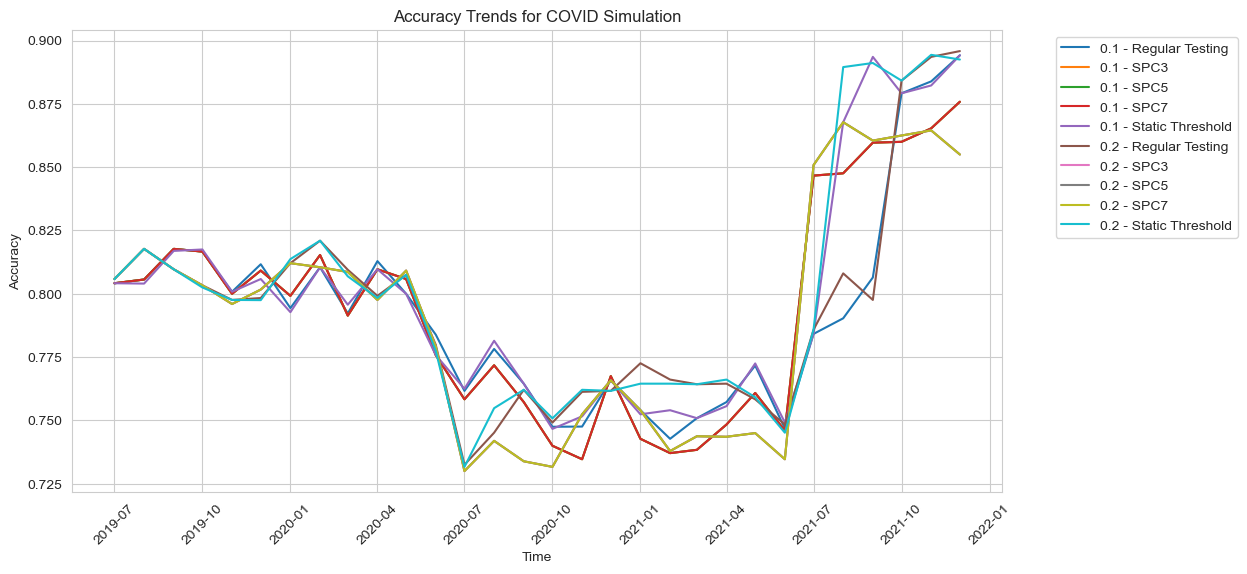

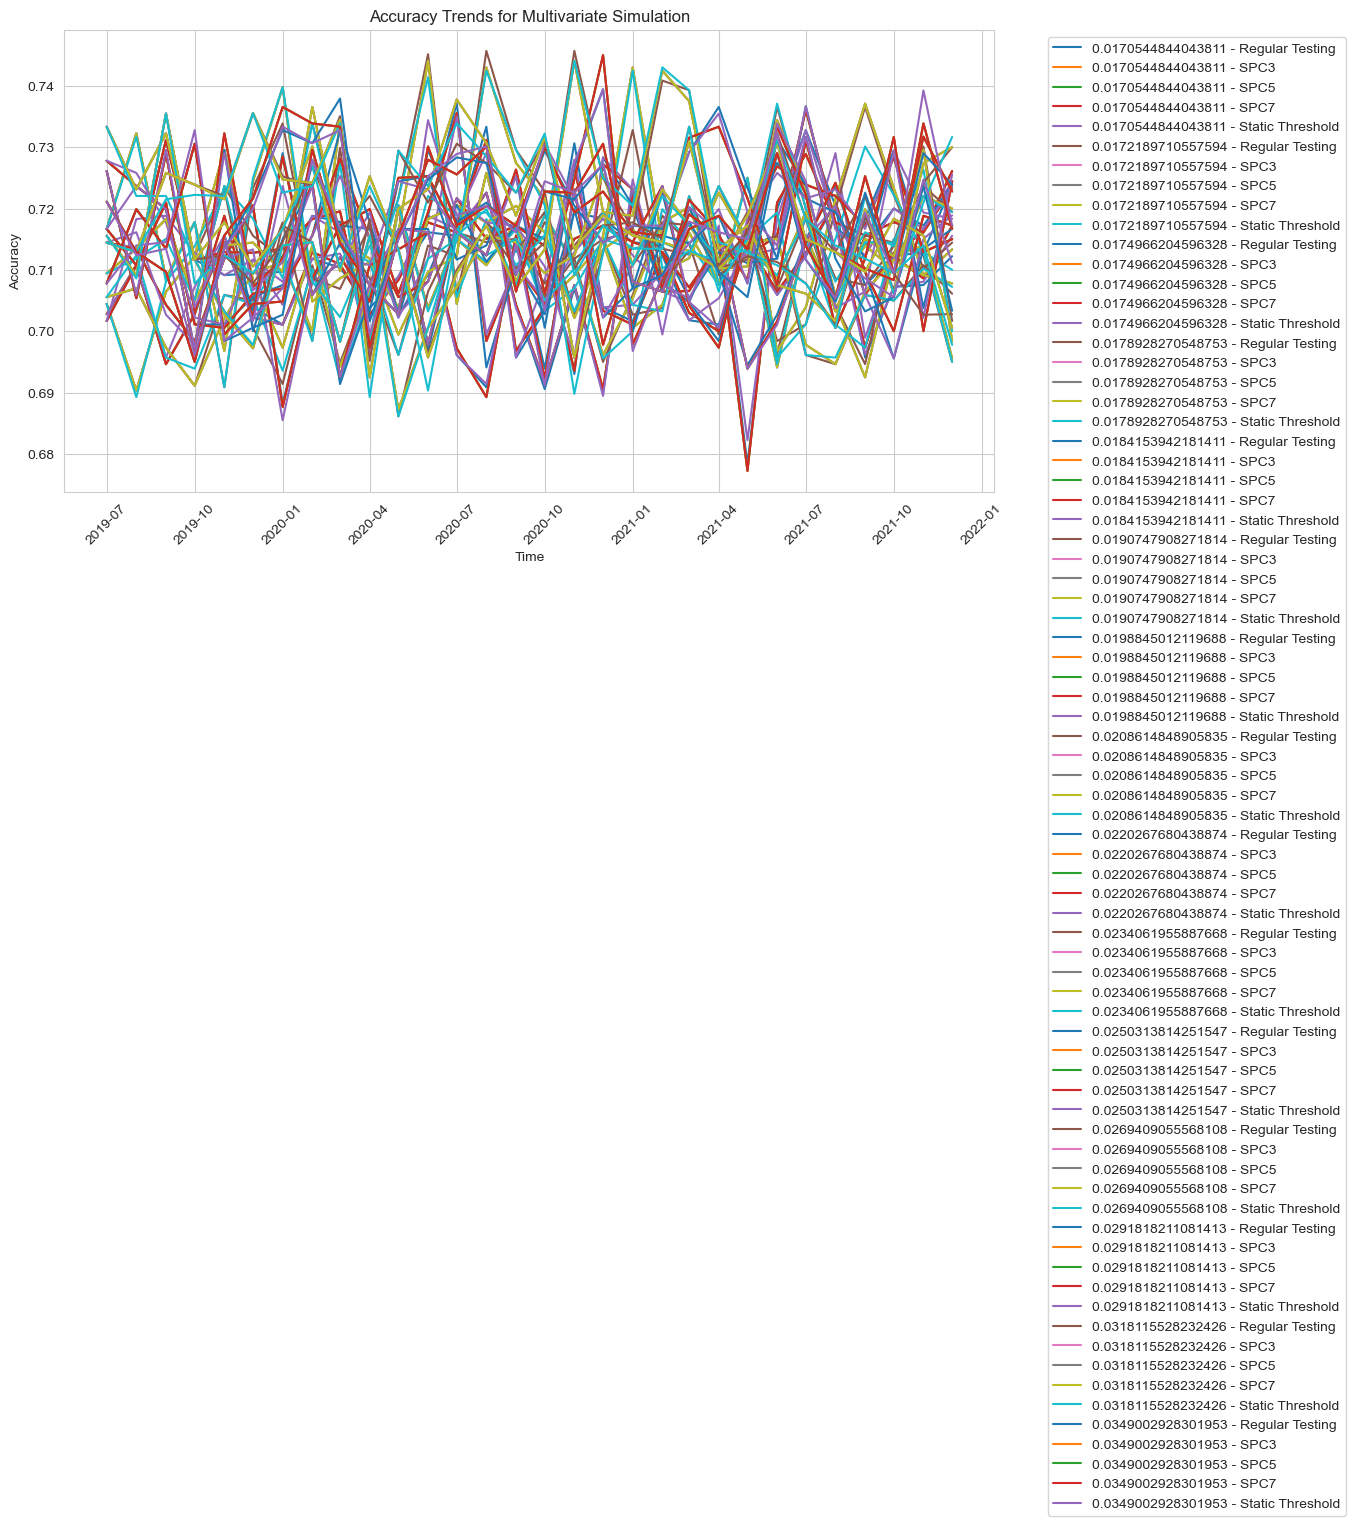

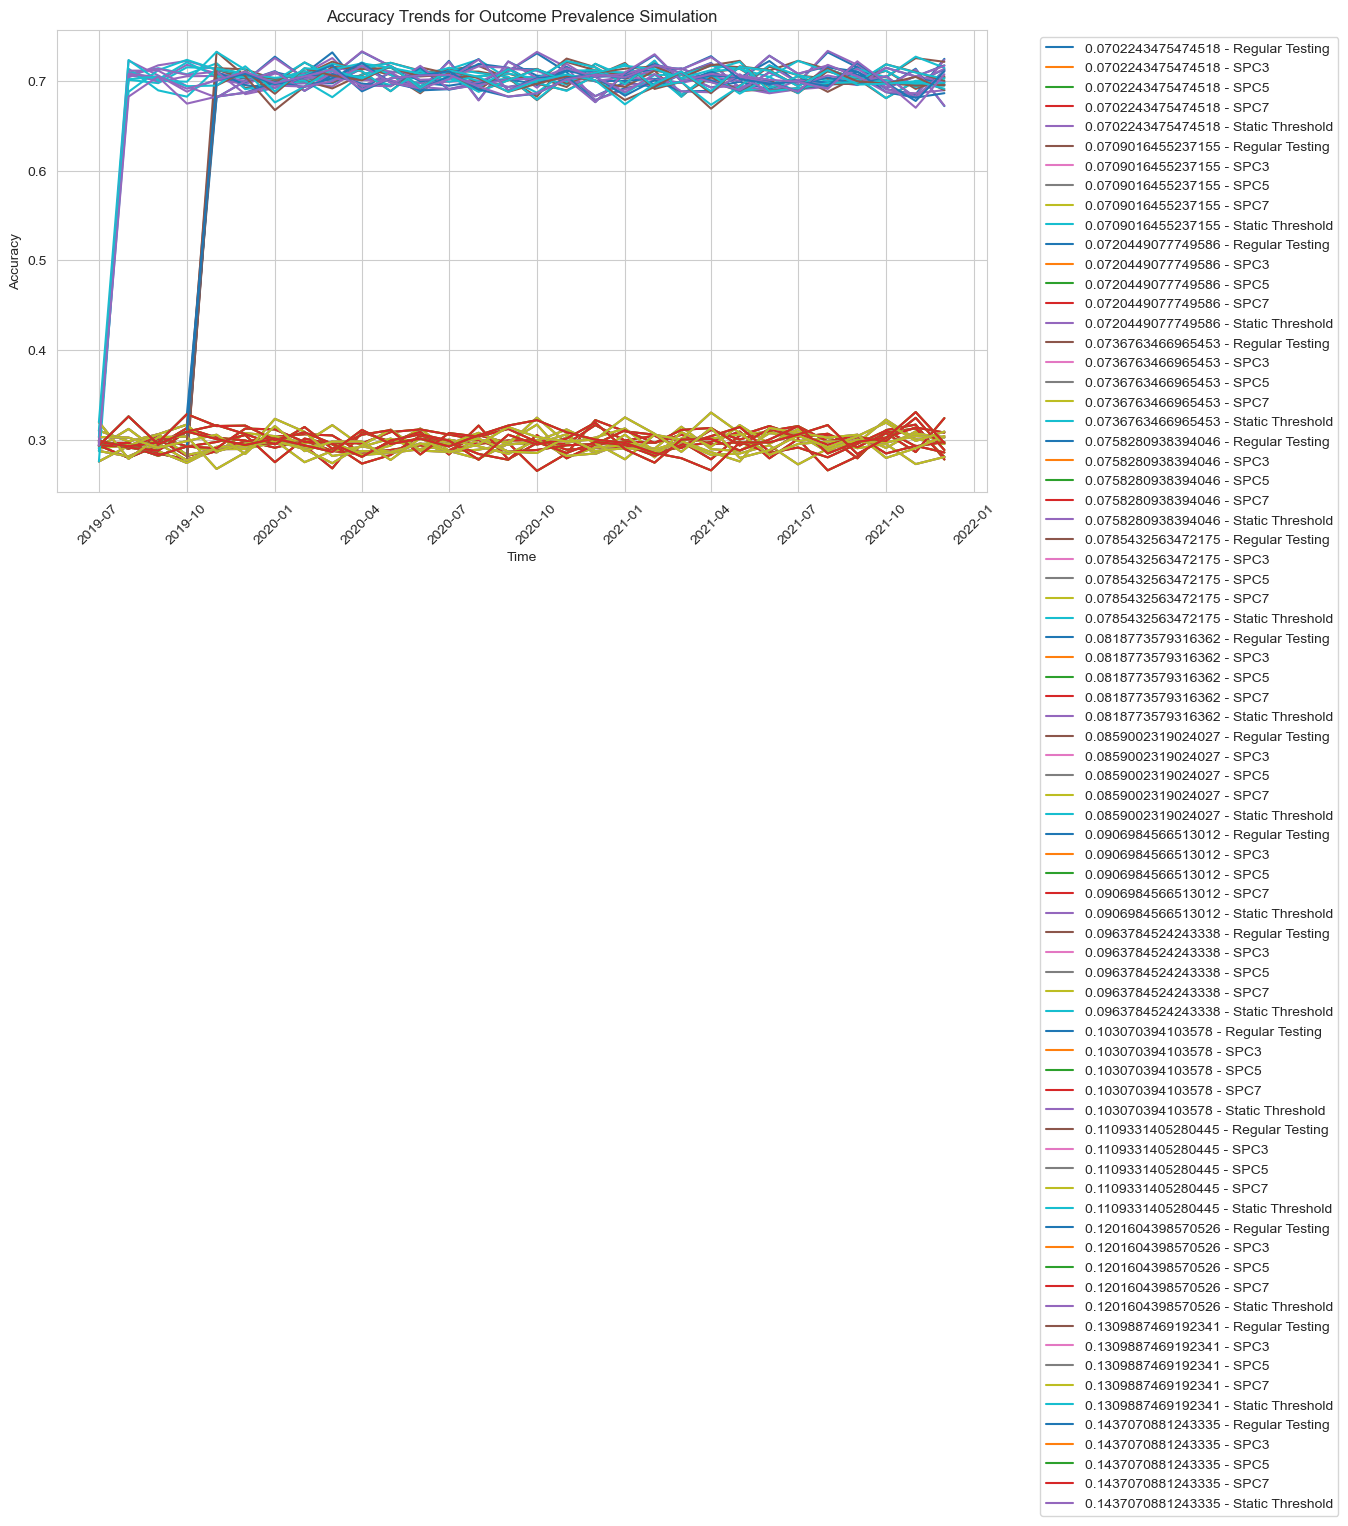

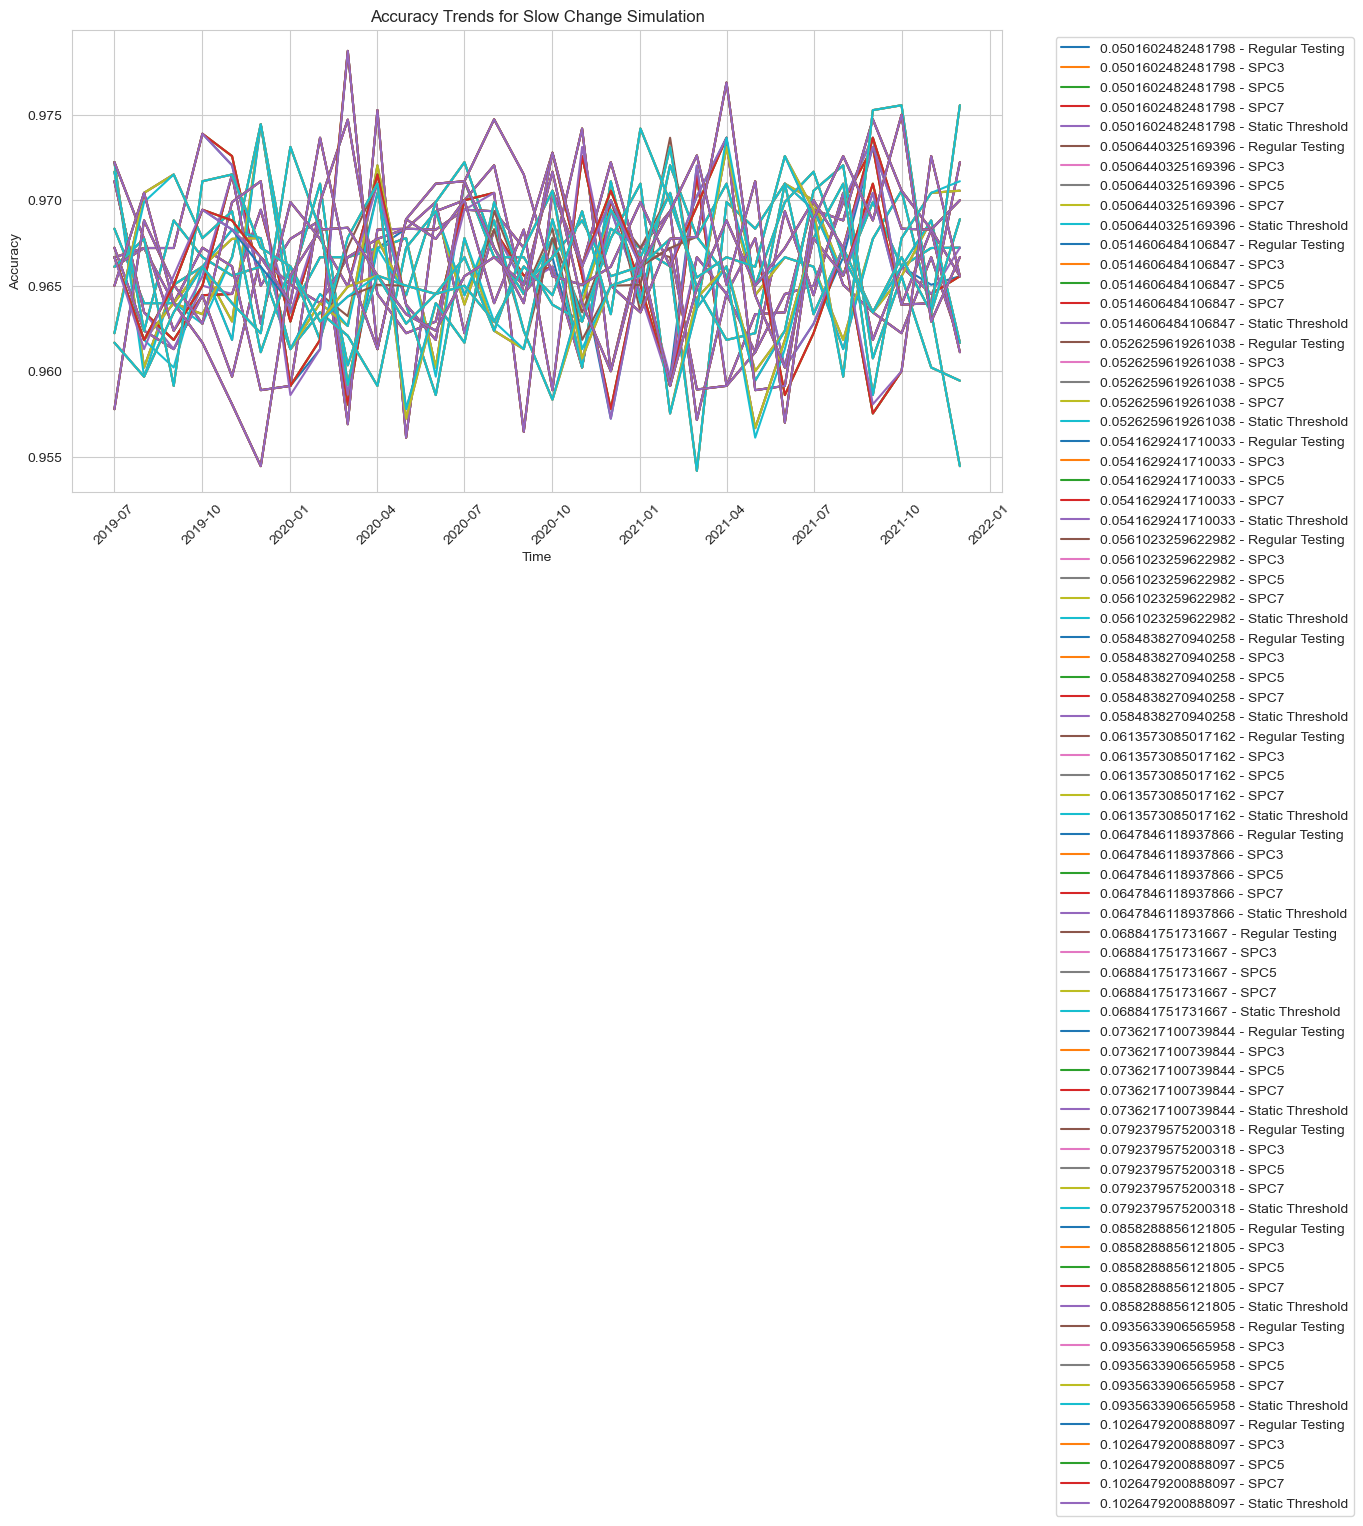

In [15]:
sns.set_style("whitegrid")

# Loop through each unique Data_type to create individual plots
for data_type, subset in metrics_df.groupby("Data_type"):
    plt.figure(figsize=(12, 6))
    
    # Plot each unique combination of impact_or_prev and method within this Data_type
    for group, subsubset in subset.groupby(["impact_or_prev", "Method"]):
        label = f"{group[0]} - {group[1]}"  # Combining impact and method for legend
        plt.plot(subsubset["Time"], subsubset["Accuracy"], label=label)

    plt.xlabel("Time")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Trends for {data_type}")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
    plt.xticks(rotation=45)
    plt.show()

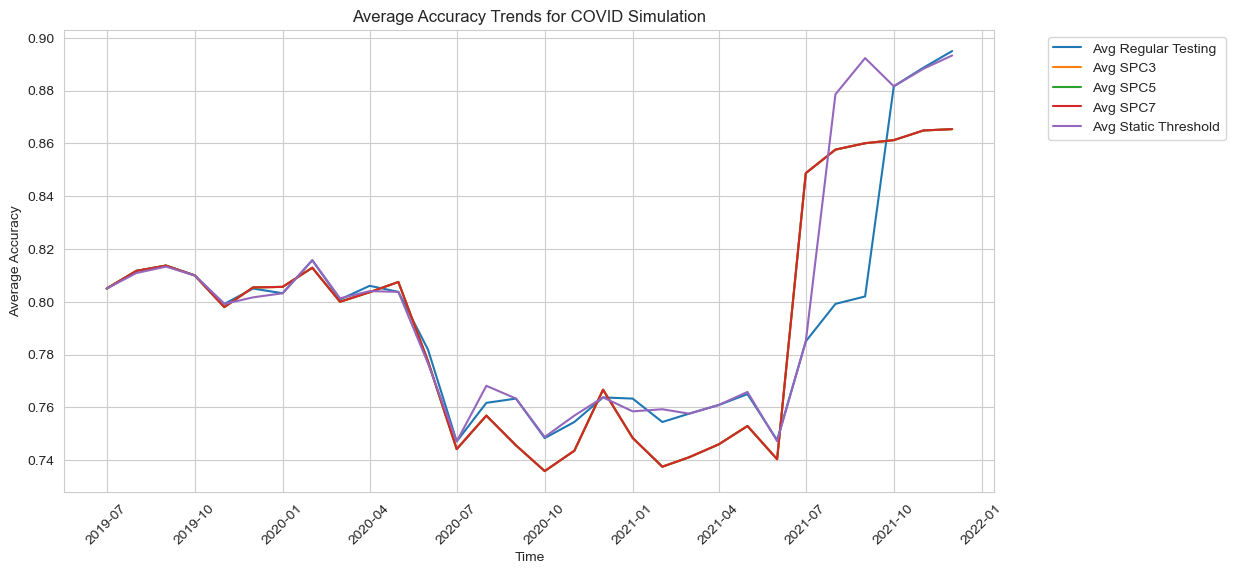

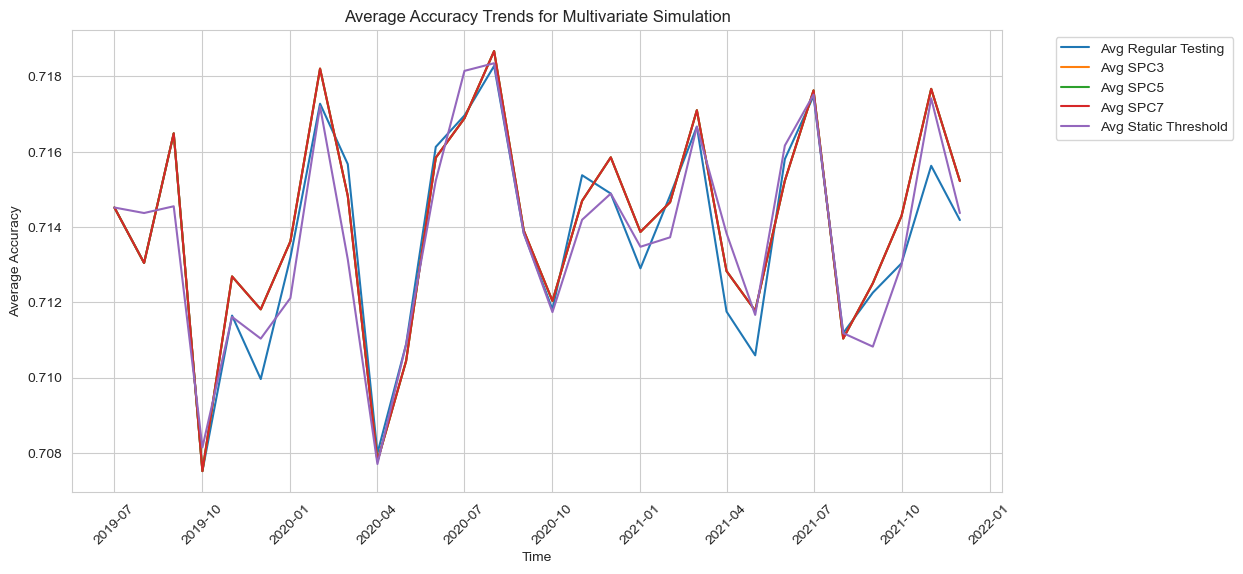

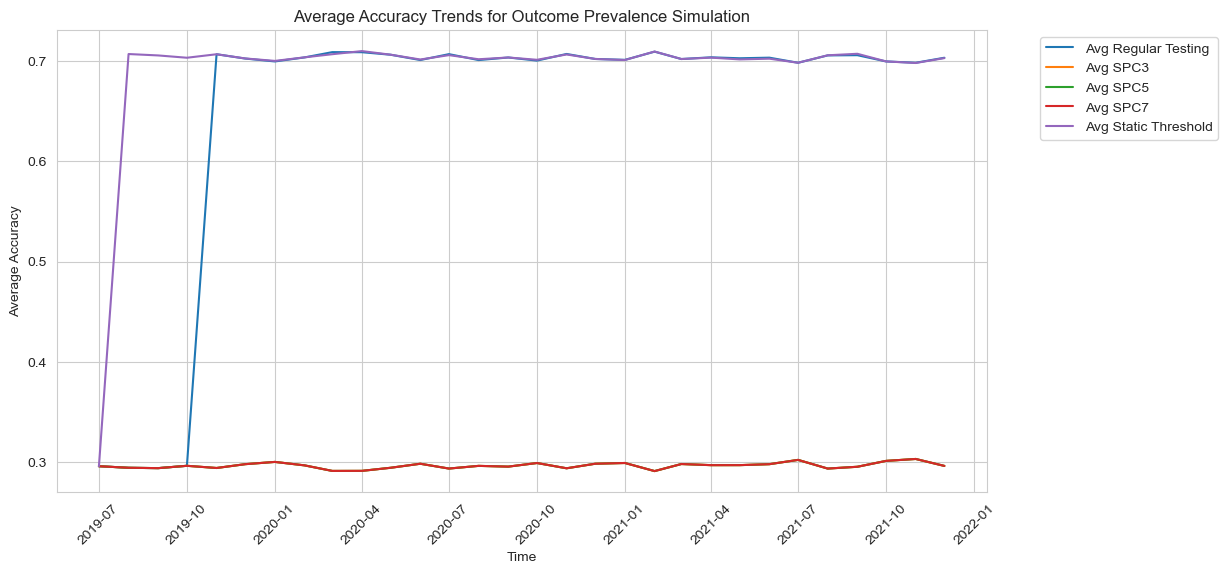

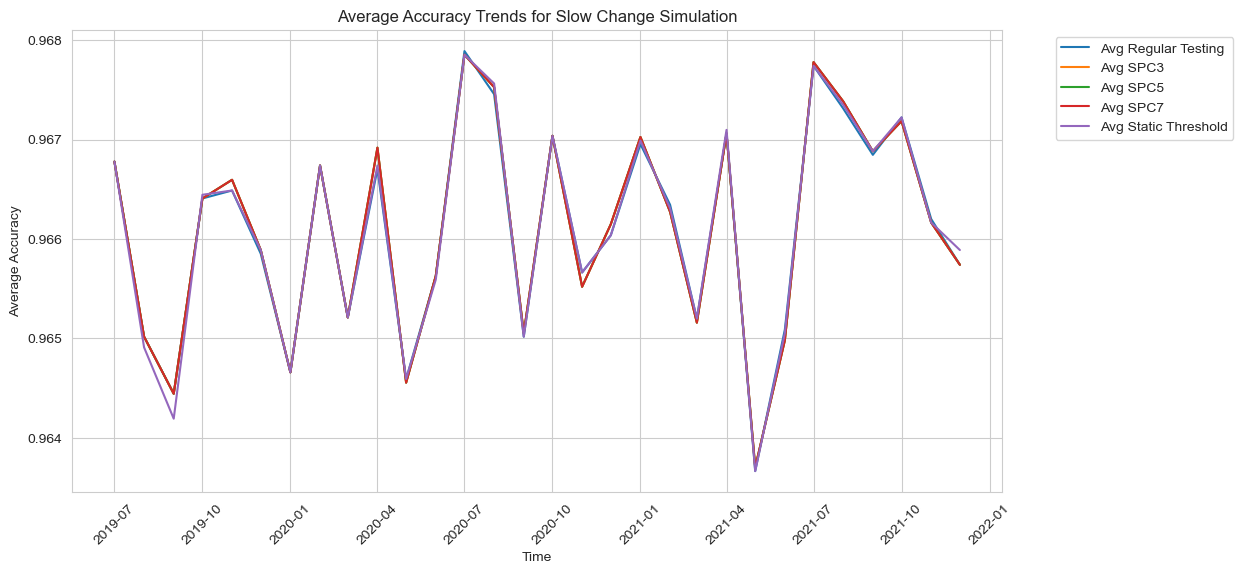

In [13]:
# Group by Time, Method, and Data_type and get the average of the metric
numeric_cols = ["Accuracy", "AUROC", "Precision"]
df_avg = metrics_df.groupby(["Time", "Method", "Data_type"], as_index=False)[numeric_cols].mean()


sns.set_style("whitegrid")

# Loop through each unique Data_type and create separate plots
for data_type, subset in df_avg.groupby("Data_type"):
    plt.figure(figsize=(12, 6))
    
    # Plot average Accuracy for each Method within Data_type
    for method, subsubset in subset.groupby("Method"):
        plt.plot(subsubset["Time"], subsubset["Accuracy"], label=f"Avg {method}")

    plt.xlabel("Time")
    plt.ylabel("Average Accuracy")
    plt.title(f"Average Accuracy Trends for {data_type}")
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
    plt.xticks(rotation=45)
    plt.show()

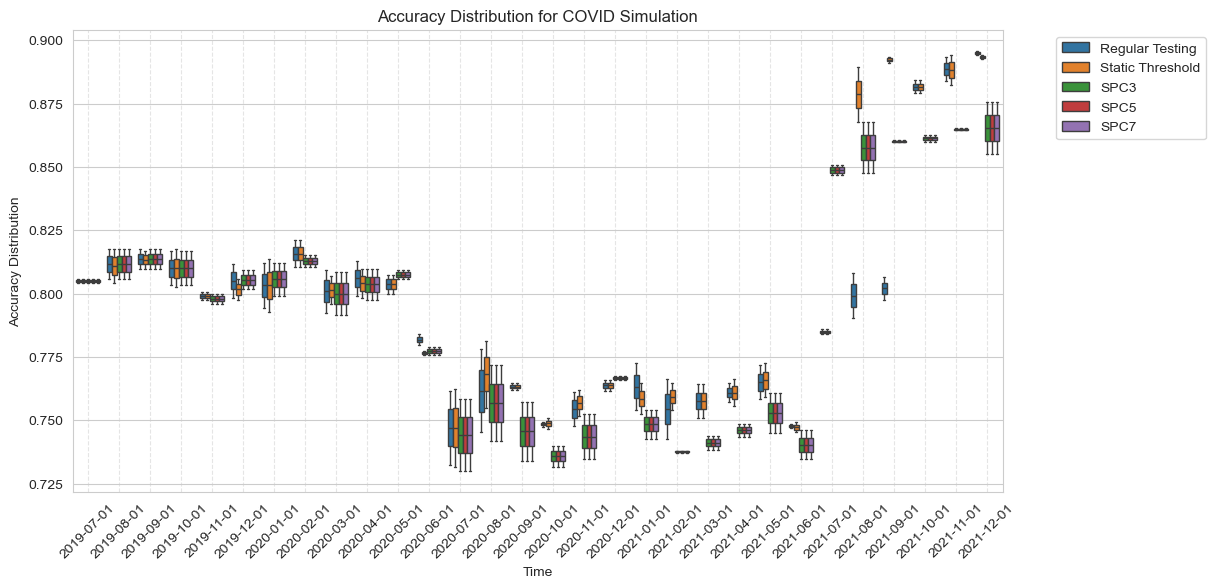

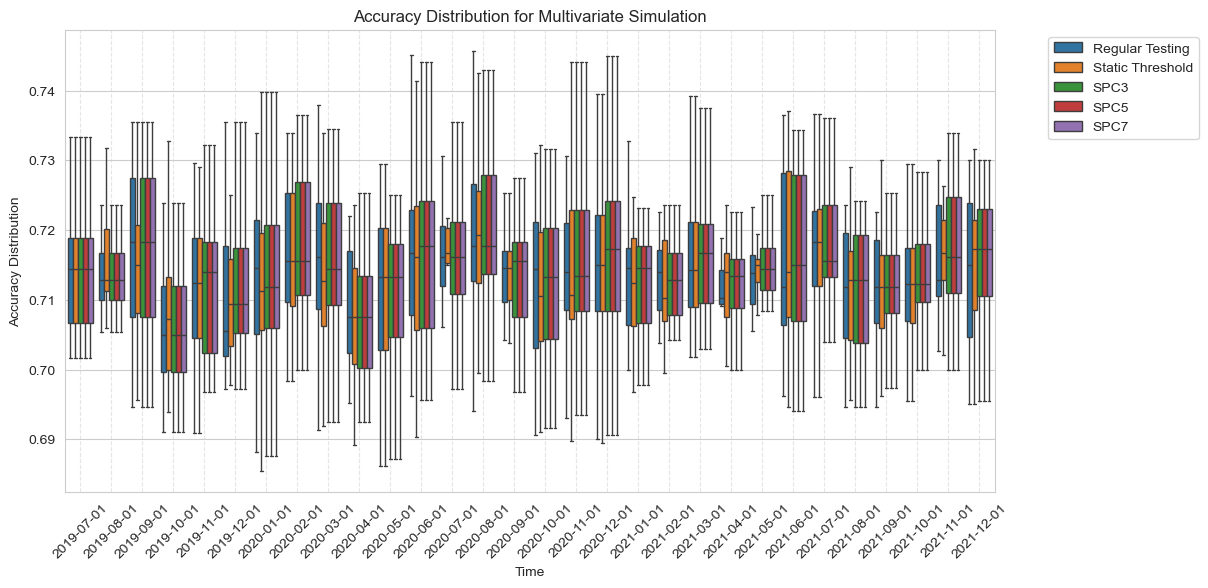

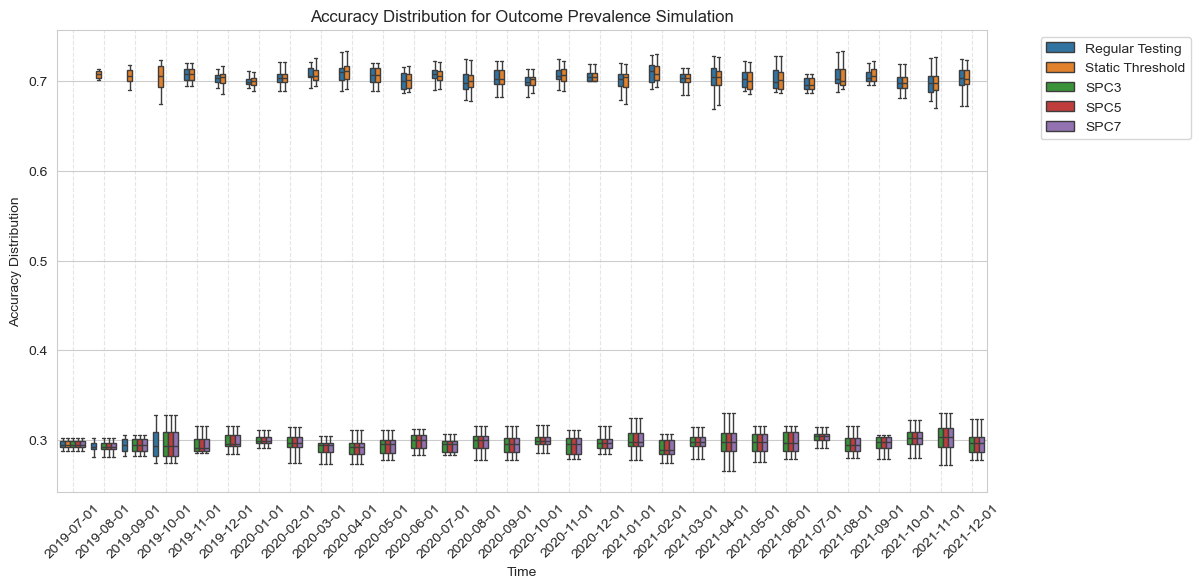

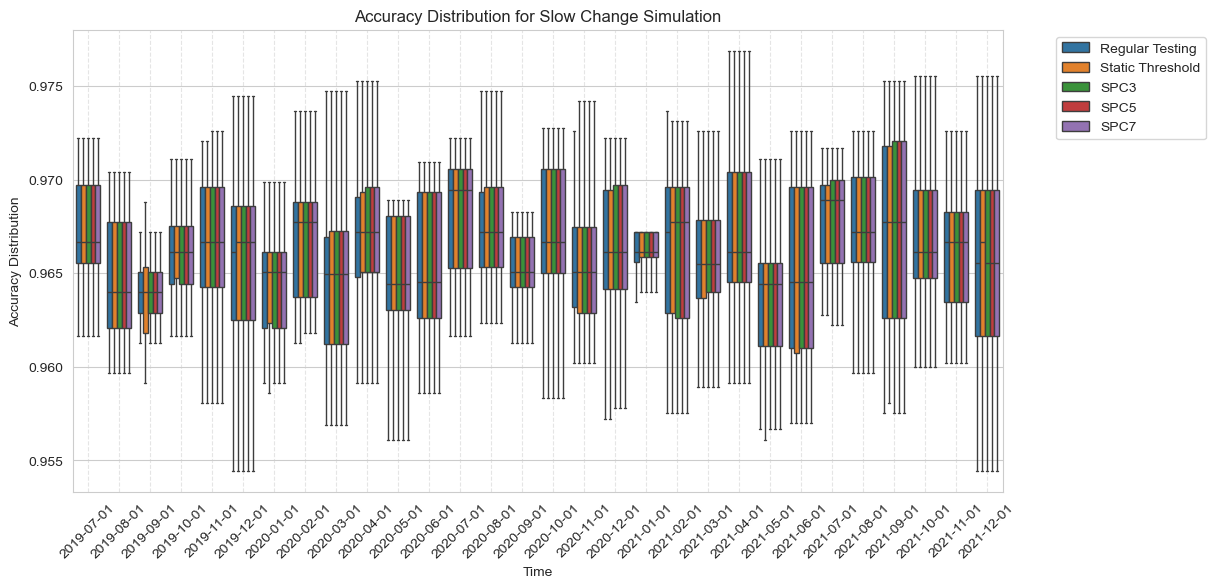

In [17]:
sns.set_style("whitegrid")

# Loop through each unique Data_type to create separate box plots
for data_type, subset in metrics_df.groupby("Data_type"):
    plt.figure(figsize=(12, 6))
    
    # Create box plot for Accuracy grouped by Time and Method
    sns.boxplot(x="Time", y="Accuracy", hue="Method", data=subset, showfliers=False)

    plt.xlabel("Time")
    plt.ylabel("Accuracy Distribution")
    plt.title(f"Accuracy Distribution for {data_type}")
    plt.xticks(rotation=45)
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

In [52]:
def count_best_methods(metrics_df, metrics=["Accuracy", "AUROC", "Precision"]):
    """
    Finds the best method for each time point based on the given performance metrics.

    Parameters:
    metrics_df (DataFrame): The dataset containing performance metrics.
    metrics (list): List of metric column names to evaluate.

    Returns:
    dict: A dictionary containing the count of times each method outperformed others for each metric.
    """
    results = {}

    for metric in metrics:
        best_methods = metrics_df.loc[metrics_df.groupby("Time")[metric].idxmax()]["Method"]
        method_counts = best_methods.value_counts()
        
        results[metric] = method_counts
        print(f"\nNumber of times each method outperformed others ({metric}):")
        print(method_counts)

    return results

# count best methods for all simulations
_ = count_best_methods(metrics_df)


Number of times each method outperformed others (Accuracy):
Method
Regular Testing    29
SPC3                1
Name: count, dtype: int64

Number of times each method outperformed others (AUROC):
Method
Regular Testing    30
Name: count, dtype: int64

Number of times each method outperformed others (Precision):
Method
Regular Testing    29
SPC3                1
Name: count, dtype: int64


In [54]:
print("############ COVID Simulation Metrics ############")
covid_metrics_df = metrics_df[metrics_df["Data_type"]=="COVID Simulation"]
# Count best method for COVID simulation
_ = count_best_methods(covid_metrics_df)
# Compute min and max values for Accuracy, AUROC, and Precision for each method
print("\nMinimum and Maximum Metrics for COVID Simulation:")
min_max_metrics = covid_metrics_df.groupby("Method")[["Accuracy", "AUROC", "Precision"]].agg(["min", "max"])
print(min_max_metrics)

print("############ Multivariate Simulation Metrics ############")
multivariate_metrics_df = metrics_df[metrics_df["Data_type"]=="Multivariate Simulation"]
_ = count_best_methods(multivariate_metrics_df)
print("\nMinimum and Maximum Metrics for Multivariate Simulation:")
min_max_metrics = multivariate_metrics_df.groupby("Method")[["Accuracy", "AUROC", "Precision"]].agg(["min", "max"])
print(min_max_metrics)

print("############ Slow Change Simulation Metrics ############")
slow_metrics_df = metrics_df[metrics_df["Data_type"]=="Slow Change Simulation"]
_ = count_best_methods(slow_metrics_df)
print("\nMinimum and Maximum Metrics for Slow Change Simulation:")
min_max_metrics = slow_metrics_df.groupby("Method")[["Accuracy", "AUROC", "Precision"]].agg(["min", "max"])
print(min_max_metrics)

print("############ Outcome Prevalence Simulation Metrics ############")
outcome_prev_metrics_df = metrics_df[metrics_df["Data_type"]=="Outcome Prevalence Simulation"]
_ = count_best_methods(outcome_prev_metrics_df)
print("\nMinimum and Maximum Metrics for Outcome Prevalence Simulation:")
min_max_metrics = outcome_prev_metrics_df.groupby("Method")[["Accuracy", "AUROC", "Precision"]].agg(["min", "max"])
print(min_max_metrics)


############ COVID Simulation Metrics ############

Number of times each method outperformed others (Accuracy):
Method
Regular Testing     15
Static Threshold    12
SPC3                 3
Name: count, dtype: int64

Number of times each method outperformed others (AUROC):
Method
Regular Testing    30
Name: count, dtype: int64

Number of times each method outperformed others (Precision):
Method
SPC3                17
Regular Testing      8
Static Threshold     5
Name: count, dtype: int64

Minimum and Maximum Metrics for COVID Simulation:
                  Accuracy               AUROC          Precision          
                       min       max       min      max       min       max
Method                                                                     
Regular Testing   0.732500  0.895833  0.770791  0.87728  0.311189  0.803030
SPC3              0.730000  0.875833  0.770791  0.87728  0.400000  0.833333
SPC5              0.730000  0.875833  0.770791  0.87728  0.400000  0.833333
SP

In [31]:
# Compute average accuracy, AUROC, and precision per method
method_avg_performance = metrics_df.groupby("Method")[["Accuracy", "AUROC", "Precision"]].mean()

# Rank methods based on average accuracy
method_avg_performance["Rank"] = method_avg_performance["Accuracy"].rank(method="dense", ascending=False)

# Print results
print("Method Rankings Based on Average Accuracy:")
print(method_avg_performance.sort_values("Rank"))

Method Rankings Based on Average Accuracy:
                  Accuracy     AUROC  Precision  Rank
Method                                               
Static Threshold  0.790319  0.693788   0.751158   1.0
Regular Testing   0.777009  0.678112   0.738312   2.0
SPC5              0.664621  0.543314   0.634025   3.0
SPC3              0.664621  0.543314   0.634025   3.0
SPC7              0.664621  0.543314   0.634025   3.0


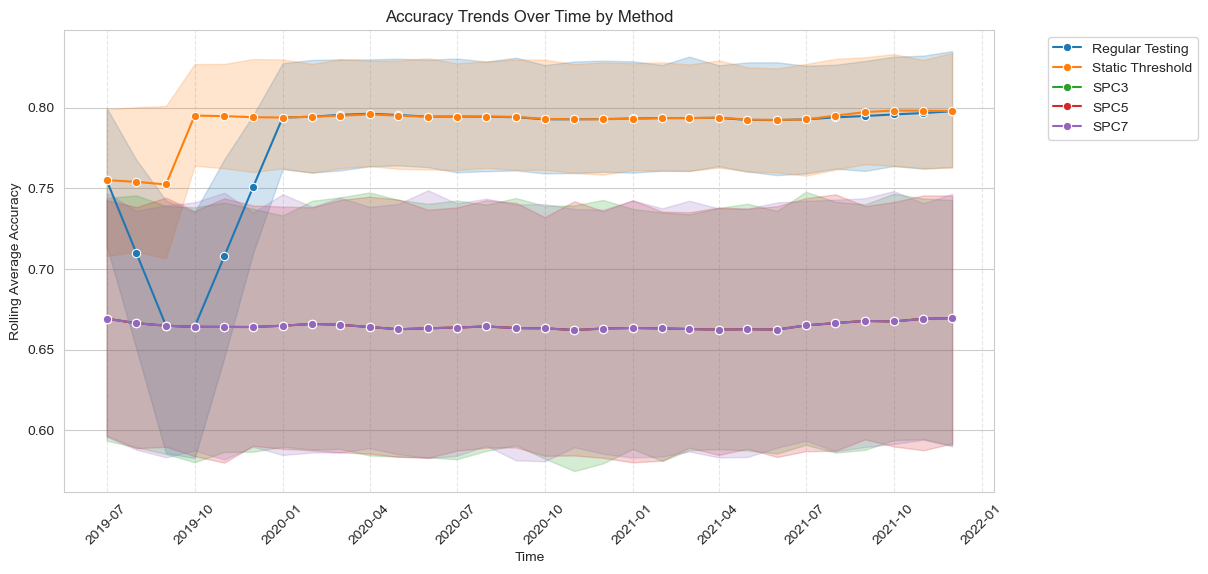

In [32]:
# Compute rolling averages for accuracy to smooth trends
metrics_df["Rolling_Accuracy"] = metrics_df.groupby("Method")["Accuracy"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Plot accuracy trends over time for each method
plt.figure(figsize=(12, 6))
sns.lineplot(data=metrics_df, x="Time", y="Rolling_Accuracy", hue="Method", marker="o")

plt.xlabel("Time")
plt.ylabel("Rolling Average Accuracy")
plt.title("Accuracy Trends Over Time by Method")
plt.xticks(rotation=45)
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()
